<h1>Course project on Technologies and Infrastructure for Big Data</h1>
<hr></hr>

<b>Project topic:</b> Automating data collection with www.flickr.com database in an image classification problem.

<b>Project executors:</b>

<ul>
    <ol type='1'>
    <li>Medvedev Anatoly Andreevich, ISU 335489.</li>
    <li>Smirnov Ivan Zakharovich, ISU 338330.</li>
    </ol>
</ul>

<a name='000'></a>

<h2>Content</h2>

<ul>
    <ol type='1'>
    <li><a href='#001'>Environment Setup</a></li>
    <li><a href='#002'>Data Parsing</a></li>
    <li><a href='#003'>Data Preprocessing</a></li>
    <li><a href='#004'>Model Training</a></li>
    <li><a href='#005'>Model Validation</a></li>
    </ol>
</ul>

<a name='001'></a>

<h2>Environment Setup</h2>

<a href='#000'>Back to content</a>

To avoid conflicts between framework versions and unwanted warnings, we have executed the script below. This allowed us to at least use `Catalyst` and `PyTorch` frameworks without conflicts in the same environment.

In [1]:
import os
import warnings

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
warnings.filterwarnings(action='ignore')

Libraries import. We used `PyTorch` framework to load and fine-tune the pretrained model, `Catalyst` framework to speed up the model training process and `FlickrAPI` to connect to the www.flickr.com database API.  We also used `PySpark` interface to access `Pandas` API through `Apache Spark` framework. This allowed us to store, access and pre-process data with high speed and optimization.

In [2]:
from catalyst import dl
import flickrapi
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torchvision
import pyspark.pandas as ps

import numpy as np
import pandas as pd
import pylab
from sklearn.model_selection import train_test_split
import seaborn as sns
import time
from tqdm import tqdm
import urllib.request
from skimage import io, transform

<a name='002'></a>

<h2>Data Parsing</h2>

<a href='#000'>Back to content</a>

Before we start parsing data, we have received key and secret code to connect to the API. You can get your own key in the Developers section of www.flickr.com or use ours.

In [3]:
API_KEY = '809322371031dd7403805902a5aaddd1'
API_SECRET = '01590df66d97c93d'

We bring to your attention solution to the problem of classifying land transport in 10 categories: `bicycle`, `bus`, `car`, `excavator`, `motorbike`, `scooter`, `snowmobile`, `train`, `truck`, `wagon`. To begin with, we created a directory in which our data set will be located.

In [4]:
labels = ['bicycle', 'bus', 'car', 'excavator', 'motorbike', 'scooter', 'snowmobile', 'train', 'truck', 'wagon']
root = 'dataset'

def create_directory(root, labels):
    os.makedirs(root) if not os.path.exists(root) else 0
    [os.makedirs(os.path.join(root, label)) for label in labels if not os.path.exists(os.path.join(root, label))]
    
    return os.listdir(root)

The final directory looks like this:
```
dataset/
       |
       bicycle/
       |      |
       |      0.jpg
       |      ...
       bus/
       ...
```

In [ ]:
create_directory(root=root, labels=labels)

['bicycle',
 'bus',
 'car',
 'excavator',
 'motorbike',
 'scooter',
 'snowmobile',
 'train',
 'truck',
 'wagon']

We have created two functions. The first one takes an image url as input and uploads it to our directory. The second function sends an API request for each class in our dataset and returns >7000 urls of the most relevant images for our queries.

It is worth paying attention to the arguments of the image search method:
- `text` - keywords in the photo description. For us, these are class names.
- `sort` - flickr's built-in sorting method. We chose sorting by relevance.
- `media` - return data type. For us, it's images.
- `extras` - image metadata. We chose `url_c`, which will return url of the image thumbnail with a size of 800 pixels on the long side, since the original images are not always available for download.
- `per_page` - number of images per query response page.
- `page` - page number of query responses.

In [5]:
def load_image(url, label, index):
    urllib.request.urlretrieve(url, os.path.join(root, label, '{}.jpg'.format(index)))

def parse_flickr(root, label, size=7000):
    api = flickrapi.FlickrAPI(api_key=API_KEY, secret=API_SECRET, format='parsed-json')
    
    label_csv = ps.DataFrame()
    per_page = 0
    index = 0
    page = 1
    
    print('Downloading photos with label "{}"...'.format(label))
    
    with tqdm(total=size) as bar:
        while index <= size:
            photos = api.photos.search(text=label, sort='relevance', media='photos',
                extras='url_c', per_page=500, page=page)['photos']
            
            dataframe = ps.DataFrame(data=photos['photo'])
            for url in dataframe['url_c'].tolist():
                try:
                    load_image(url, label, index)
                    time.sleep(0.1)
                    
                    dataframe.loc[index, 'label'] = labels.index(label)
                    dataframe.loc[index, 'root'] = os.path.join(label, '{}.jpg'.format(index))
                    index = index + 1
                    bar.update(1)
                except:
                    pass
                
                per_page = per_page + 1
            
            if not per_page % 500 and per_page !=0:
                page = page + 1
            
            label_csv = ps.concat([label_csv, dataframe[['root', 'label', 'url_c']]], ignore_index=True)
            label_csv.to_csv(os.path.join(root, label, '{}.csv').format(label))
        bar.close()
    
    return label_csv

We have run queries for each of our classes. We have added logging and a progress bar to visualize the process of uploading images.

In [ ]:
label_csv = ps.DataFrame()

for label in labels:
    label_csv = ps.concat([label_csv, parse_flickr(root=root, label=label)], ignore_index=True)

print('Result spreadsheet:')
label_csv.to_csv(os.path.join(root, 'labels.csv'))
label_csv.head()

7477it [52:58,  2.35it/s]                                                                                              


7477it [38:21,  3.25it/s]                                                                                              


7475it [1:00:33,  2.06it/s]                                                                                            


7473it [1:06:24,  1.88it/s]                                                                                            

Result spreadsheet:


,root,label,url_c
0,snowmobile\0.jpg,0.0,https://live.staticflickr.com/7252/7561726504_...
1,snowmobile\1.jpg,0.0,NaN
2,snowmobile\2.jpg,0.0,https://live.staticflickr.com/191/488913931_4f...
3,snowmobile\3.jpg,0.0,https://live.staticflickr.com/2902/14008626942...
4,snowmobile\4.jpg,0.0,https://live.staticflickr.com/5136/5424420272_...


As you can see from the example, we had to clear the resulting csv file from nan values, which were obtained as a result of an unsuccessful call to the image url. This happens due to the fact that owners of the images do not allow access to upload their images.

<a name='003'></a>

<h2>Data Preprocessing</h2>

<a href='#000'>Back to content</a>

Before starting to train the model, we have preprocessed the data.

We used `ResNet-18` model pre-trained on the ImageNet dataset. In order to increase the efficiency of training, we used augmentation close to ImageNet. We applied image resizing to 224×224 size and normalization of pixel intensity values. The size of the training and test samples were 75% and 25% of the total set, respectively.

We created class to pack custom dataset that accessed a csv file with image name and label using `PySpark`. Class `FlickrDataset` returns a pair of image, `features`, and label, `targets`, in tensor format.

In [6]:
class FlickrDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the frames.
            transform (callable, optional): Optional transform object.
        """
        # Read person ids and frame ids as string type.
        self.dataframe = ps.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, index):
        label = self.dataframe.loc[index, 'label'].astype('float')
        folder = labels[int(label)]

        image_name = os.path.join(self.root_dir, folder, '{}.jpg'.format(self.dataframe.loc[index, 'root']))
        image = io.imread(image_name)
        
        sample = {'features': image, 'targets': label}
        
        # Image augmentation is recommended.
          # See more: https://pytorch.org/vision/master/transforms.html.
        if self.transform:
            sample = self.transform(sample)
        return sample

We also had to create our own classes for image augmentation, since standard transformations from `PyTorch` are not always able to work with custom datasets.

Class `Rescale` resizes original image to the desired size. Arguments are written in the comments to the class.

Class `ToTensor` converts input to tensor format. It is worth noting that image is converted to `FloatTensor` format, when target class is converted to `LongTensor`. This is due to the peculiarities of the model weight type and the loss function, which only works with `LongTensor` when using `Catalyst` framework.

Class `Normalize` performs data normalization using `ImageNet` normalization options.

In [7]:
class Rescale(object):
    """Rescale image in a sample to a given size."""
    
    def __init__(self, output_size):
        """
        Args:
            output_size (tuple or int): Desired output size.
        """
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
    
    def __call__(self, sample):
        image, label = sample['features'], sample['targets']
        
        height, width = image.shape[:2]
        if isinstance(self.output_size, int):
            if height > width:
                out_height, out_width = self.output_size * height / width, self.output_size
            else:
                out_height, out_width = self.output_size, self.output_size * width / height
        else:
            out_height, out_width = self.output_size
        
        out_height, out_width = int(out_height), int(out_width)
        
        image = transform.resize(image, (out_height, out_width))
        
        return {'features': image, 'targets': label}

class ToTensor(object):
    """Convert ndarrays in sample to tensors."""
    
    def __call__(self, sample):
        image, label = sample['features'], sample['targets']
        
        # Swap color axis.
        image = image.transpose((2, 0, 1))
        return {'features': torch.from_numpy(image).float(), 'targets': torch.tensor(label).type(torch.LongTensor)}

class Normalize(object):
    """Normilize image in a sample."""
    
    def __call__(self, sample):
        image, label = sample['features'], sample['targets']
        
        normalization = torchvision.transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        return {'features': normalization(image).float(), 'targets': label.type(torch.LongTensor)}

In [8]:
transforms = torchvision.transforms.Compose([Rescale(output_size=(224, 224)), ToTensor(), Normalize()])

Splitting cvs file into training and test sets.

In [ ]:
labels_data = ps.read_csv(os.path.join(root, 'labels.csv'))
train_dataset, test_dataset = train_test_split(labels_data, test_size=0.25, shuffle=True)

train_dataset.to_csv(os.path.join(root, 'train.csv'), index=False)
test_dataset.to_csv(os.path.join(root, 'test.csv'), index=False)

Packing custom dataset with passing object for data augmentation.

In [9]:
train_dataset = FlickrDataset(csv_file='train.csv', root_dir=root, transform=transforms)
test_dataset = FlickrDataset(csv_file='test.csv', root_dir=root, transform=transforms)

We have packed datasets into batches, each with 32 pairs (image, label). Visualization of the first batch of the training set is shown below.

In [13]:
loaders = {
    'train': torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True),
    'valid': torch.utils.data.DataLoader(dataset=test_dataset, batch_size=32, shuffle=True),
}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


excavator car excavator bus snowmobile bus excavator train scooter bicycle bus train bicycle car train bicycle motorbike scooter excavator motorbike train scooter bicycle wagon train snowmobile truck snowmobile bicycle wagon truck wagon


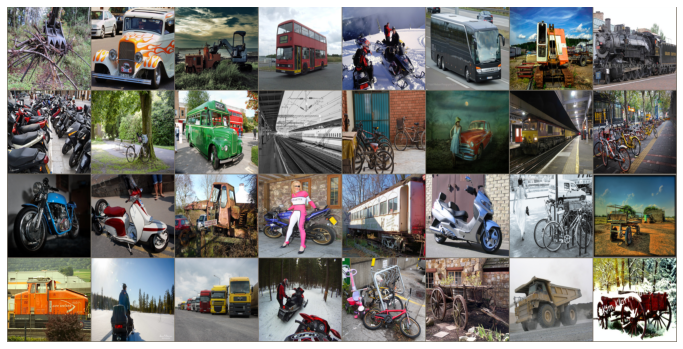

In [14]:
def plot_dataloader(dataloader):
    images, targets = dataloader
    images = torchvision.utils.make_grid(images).numpy()
    images = np.transpose(images, axes=(1, 2, 0))
    images = np.array([0.229, 0.224, 0.225]) * images + np.array([0.485, 0.456, 0.406])
    
    print(' '.join(f'{labels[int(targets[i])]}' for i in range(32)))
    pylab.figure(figsize=(12, 12))
    pylab.imshow(images)
    pylab.axis('off')
    pylab.show()

plot_dataloader(next(iter(loaders['train'])))

<a name='004'></a>

<h2>Model Training</h2>

<a href='#000'>Back to content</a>

We used `ResNet-18` model pre-trained on the ImageNet dataset. To work with it, we frozed model layers, except for the batch normalization and the last two convolutional layers. This allowed us to use the experience of ImageNet training and at the same time to teach model to find high-frequency features on our images. The output of our model is 10 neurons.

In [15]:
def resnet18(pretrained=True):
    model = torchvision.models.resnet18(pretrained=pretrained)
    
    for name, parameter in model.named_parameters():
        if('bn' not in name):
            parameter.requires_grad = False
    
    # Freeze all convolution layers except the last two.
    unfrozen_layers = [model.layer3, model.layer4]
    for layer in unfrozen_layers:
        for parameter in layer.parameters():
            parameter.requires_grad = True
    
    model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features, 500),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.5),
        nn.Linear(500, 10)
    )
    
    return model

We chose `CrossEntropy` as the loss function, and `RMSprop` algorithm as the optimizer.

In [16]:
model = resnet18(pretrained=True)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.02)

Using `Catalyst` framework, we trained the model for 25 epochs. Logging of the model prediction accuracy and losses after each epoch on the training and tets samples is shown below.

In [17]:
runner = dl.SupervisedRunner(
    input_key='features', output_key='logits', target_key='targets', loss_key='loss'
)

In [18]:
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    loaders=loaders,
    num_epochs=25,
    callbacks=[dl.AccuracyCallback(input_key='logits', target_key='targets')],
    logdir='./logs',
    valid_loader='valid',
    valid_metric='loss',
    minimize_valid_metric=True,
    verbose=True,
)

1/25 * Epoch (train):   0%|          | 0/1815 [00:00<?, ?it/s]

train (1/25) accuracy01: 0.4218413573366441 | accuracy01/std: 0.20911984656914137 | loss: 4.195272974571223 | loss/mean: 4.195272974571223 | loss/std: 67.61115137158721 | lr: 0.02 | momentum: 0.0


1/25 * Epoch (valid):   0%|          | 0/522 [00:00<?, ?it/s]

valid (1/25) accuracy01: 0.4379233858934959 | accuracy01/std: 0.09041095426764668 | loss: 2.5549752766562492 | loss/mean: 2.5549752766562492 | loss/std: 0.6344870065278879 | lr: 0.02 | momentum: 0.0
* Epoch (1/25) 


2/25 * Epoch (train):   0%|          | 0/1815 [00:00<?, ?it/s]

train (2/25) accuracy01: 0.7646025320898592 | accuracy01/std: 0.08450889118838531 | loss: 0.7402157401529857 | loss/mean: 0.7402157401529857 | loss/std: 0.27966910704352016 | lr: 0.02 | momentum: 0.0


2/25 * Epoch (valid):   0%|          | 0/522 [00:00<?, ?it/s]

valid (2/25) accuracy01: 0.6933637072153715 | accuracy01/std: 0.0819808619251368 | loss: 1.681833890807778 | loss/mean: 1.681833890807778 | loss/std: 0.6478209676061272 | lr: 0.02 | momentum: 0.0
* Epoch (2/25) 


3/25 * Epoch (train):   0%|          | 0/1815 [00:00<?, ?it/s]

train (3/25) accuracy01: 0.8270260959517151 | accuracy01/std: 0.07193636091701747 | loss: 0.5681544913831642 | loss/mean: 0.5681544913831642 | loss/std: 0.25045860857514446 | lr: 0.02 | momentum: 0.0


3/25 * Epoch (valid):   0%|          | 0/522 [00:00<?, ?it/s]

valid (3/25) accuracy01: 0.8744679575600747 | accuracy01/std: 0.05882327525732524 | loss: 0.3851134348016422 | loss/mean: 0.3851134348016422 | loss/std: 0.17797733902188143 | lr: 0.02 | momentum: 0.0
* Epoch (3/25) 


4/25 * Epoch (train):   0%|          | 0/1815 [00:00<?, ?it/s]

train (4/25) accuracy01: 0.8582723279648606 | accuracy01/std: 0.0659159717272188 | loss: 0.4750619206735592 | loss/mean: 0.4750619206735592 | loss/std: 0.2319120547981669 | lr: 0.02 | momentum: 0.0


4/25 * Epoch (valid):   0%|          | 0/522 [00:00<?, ?it/s]

valid (4/25) accuracy01: 0.9328577423415865 | accuracy01/std: 0.04522338070097122 | loss: 0.2259334007779561 | loss/mean: 0.2259334007779561 | loss/std: 0.14652763273087618 | lr: 0.02 | momentum: 0.0
* Epoch (4/25) 


5/25 * Epoch (train):   0%|          | 0/1815 [00:00<?, ?it/s]

train (5/25) accuracy01: 0.8748772715610525 | accuracy01/std: 0.06071890027056198 | loss: 0.4265017973525552 | loss/mean: 0.4265017973525552 | loss/std: 0.2202522317177815 | lr: 0.02 | momentum: 0.0


5/25 * Epoch (valid):   0%|          | 0/522 [00:00<?, ?it/s]

valid (5/25) accuracy01: 0.8669744020142682 | accuracy01/std: 0.0624417945131143 | loss: 1.0133914299977889 | loss/mean: 1.0133914299977889 | loss/std: 0.8109358972928243 | lr: 0.02 | momentum: 0.0
* Epoch (5/25) 


6/25 * Epoch (train):   0%|          | 0/1815 [00:00<?, ?it/s]

train (6/25) accuracy01: 0.8843510464297105 | accuracy01/std: 0.05887155456705694 | loss: 0.39450502730023695 | loss/mean: 0.39450502730023695 | loss/std: 0.251973562305414 | lr: 0.02 | momentum: 0.0


6/25 * Epoch (valid):   0%|          | 0/522 [00:00<?, ?it/s]

valid (6/25) accuracy01: 0.9675079431760205 | accuracy01/std: 0.03200321251554768 | loss: 0.1079115008829364 | loss/mean: 0.1079115008829364 | loss/std: 0.0899372402059199 | lr: 0.02 | momentum: 0.0
* Epoch (6/25) 


7/25 * Epoch (train):   0%|          | 0/1815 [00:00<?, ?it/s]

train (7/25) accuracy01: 0.8950994746361198 | accuracy01/std: 0.053568895487820484 | loss: 0.3629072835711108 | loss/mean: 0.3629072835711108 | loss/std: 0.23335808407840353 | lr: 0.02 | momentum: 0.0


7/25 * Epoch (valid):   0%|          | 0/522 [00:00<?, ?it/s]

valid (7/25) accuracy01: 0.9407709369977586 | accuracy01/std: 0.04060325001993213 | loss: 0.1820254308465187 | loss/mean: 0.1820254308465187 | loss/std: 0.11949354360987004 | lr: 0.02 | momentum: 0.0
* Epoch (7/25) 


8/25 * Epoch (train):   0%|          | 0/1815 [00:00<?, ?it/s]

train (8/25) accuracy01: 0.9010765653259849 | accuracy01/std: 0.054624949281534003 | loss: 0.3369686861297349 | loss/mean: 0.3369686861297349 | loss/std: 0.2241853801393353 | lr: 0.02 | momentum: 0.0


8/25 * Epoch (valid):   0%|          | 0/522 [00:00<?, ?it/s]

valid (8/25) accuracy01: 0.9485042863137699 | accuracy01/std: 0.03923078730886516 | loss: 0.17339552853876708 | loss/mean: 0.17339552853876708 | loss/std: 0.130537692925469 | lr: 0.02 | momentum: 0.0
* Epoch (8/25) 


9/25 * Epoch (train):   0%|          | 0/1815 [00:00<?, ?it/s]

train (9/25) accuracy01: 0.9083972095447275 | accuracy01/std: 0.05443958226466455 | loss: 0.3155515608558794 | loss/mean: 0.3155515608558794 | loss/std: 0.23356606091400067 | lr: 0.02 | momentum: 0.0


9/25 * Epoch (valid):   0%|          | 0/522 [00:00<?, ?it/s]

valid (9/25) accuracy01: 0.9809963431448959 | accuracy01/std: 0.024948497041148997 | loss: 0.058202614857557865 | loss/mean: 0.058202614857557865 | loss/std: 0.05480522247123017 | lr: 0.02 | momentum: 0.0
* Epoch (9/25) 


10/25 * Epoch (train):   0%|          | 0/1815 [00:00<?, ?it/s]

train (10/25) accuracy01: 0.9151322022251104 | accuracy01/std: 0.05078102483595944 | loss: 0.296472388487969 | loss/mean: 0.296472388487969 | loss/std: 0.21083790030728983 | lr: 0.02 | momentum: 0.0


10/25 * Epoch (valid):   0%|          | 0/522 [00:00<?, ?it/s]

valid (10/25) accuracy01: 0.9486841316467834 | accuracy01/std: 0.0377429116454366 | loss: 0.2544325804954514 | loss/mean: 0.2544325804954514 | loss/std: 0.2791565362262784 | lr: 0.02 | momentum: 0.0
* Epoch (10/25) 


11/25 * Epoch (train):   0%|          | 0/1815 [00:00<?, ?it/s]

train (11/25) accuracy01: 0.9171303074752706 | accuracy01/std: 0.04994773964856988 | loss: 0.2941299226916269 | loss/mean: 0.2941299226916269 | loss/std: 0.2384432222139951 | lr: 0.02 | momentum: 0.0


11/25 * Epoch (valid):   0%|          | 0/522 [00:00<?, ?it/s]

valid (11/25) accuracy01: 0.9693663449433488 | accuracy01/std: 0.02845170533261593 | loss: 0.0980523139215523 | loss/mean: 0.0980523139215523 | loss/std: 0.12385694349636693 | lr: 0.02 | momentum: 0.0
* Epoch (11/25) 


12/25 * Epoch (train):   0%|          | 0/1815 [00:00<?, ?it/s]

train (12/25) accuracy01: 0.9207647920075789 | accuracy01/std: 0.05031261750004858 | loss: 0.27873412962274974 | loss/mean: 0.27873412962274974 | loss/std: 0.24245518903377042 | lr: 0.02 | momentum: 0.0


12/25 * Epoch (valid):   0%|          | 0/522 [00:00<?, ?it/s]

valid (12/25) accuracy01: 0.9941850008992269 | accuracy01/std: 0.013196302183583199 | loss: 0.025754413442128112 | loss/mean: 0.025754413442128112 | loss/std: 0.02638028559122707 | lr: 0.02 | momentum: 0.0
* Epoch (12/25) 


13/25 * Epoch (train):   0%|          | 0/1815 [00:00<?, ?it/s]

train (13/25) accuracy01: 0.9234002239255875 | accuracy01/std: 0.0496229879270418 | loss: 0.27023062013309723 | loss/mean: 0.27023062013309723 | loss/std: 0.24071891882340082 | lr: 0.02 | momentum: 0.0


13/25 * Epoch (valid):   0%|          | 0/522 [00:00<?, ?it/s]

valid (13/25) accuracy01: 0.9842935075834781 | accuracy01/std: 0.021828027143951417 | loss: 0.06417217105788985 | loss/mean: 0.06417217105788985 | loss/std: 0.11869826490808032 | lr: 0.02 | momentum: 0.0
* Epoch (13/25) 


14/25 * Epoch (train):   0%|          | 0/1815 [00:00<?, ?it/s]

train (14/25) accuracy01: 0.9297218155197661 | accuracy01/std: 0.04656713885125164 | loss: 0.25423090994286257 | loss/mean: 0.25423090994286257 | loss/std: 0.23930728128038906 | lr: 0.02 | momentum: 0.0


14/25 * Epoch (valid):   0%|          | 0/522 [00:00<?, ?it/s]

valid (14/25) accuracy01: 0.9691864996103352 | accuracy01/std: 0.03207629244711757 | loss: 0.11005471149001059 | loss/mean: 0.11005471149001059 | loss/std: 0.12492132447138464 | lr: 0.02 | momentum: 0.0
* Epoch (14/25) 


15/25 * Epoch (train):   0%|          | 0/1815 [00:00<?, ?it/s]

train (15/25) accuracy01: 0.9337180260098188 | accuracy01/std: 0.04549018817963284 | loss: 0.23634733333439342 | loss/mean: 0.23634733333439342 | loss/std: 0.19507171347721658 | lr: 0.02 | momentum: 0.0


15/25 * Epoch (valid):   0%|          | 0/522 [00:00<?, ?it/s]

valid (15/25) accuracy01: 0.997422216893473 | accuracy01/std: 0.008812615379856887 | loss: 0.012225663926076278 | loss/mean: 0.012225663926076278 | loss/std: 0.01612207612877948 | lr: 0.02 | momentum: 0.0
* Epoch (15/25) 


16/25 * Epoch (train):   0%|          | 0/1815 [00:00<?, ?it/s]

train (16/25) accuracy01: 0.933838601326328 | accuracy01/std: 0.04548230257240154 | loss: 0.23312973785262656 | loss/mean: 0.23312973785262656 | loss/std: 0.22081086333886887 | lr: 0.02 | momentum: 0.0


16/25 * Epoch (valid):   0%|          | 0/522 [00:00<?, ?it/s]

valid (16/25) accuracy01: 0.9940651040105508 | accuracy01/std: 0.01436859605461188 | loss: 0.03257861006041119 | loss/mean: 0.03257861006041119 | loss/std: 0.12308605144726034 | lr: 0.02 | momentum: 0.0
* Epoch (16/25) 


17/25 * Epoch (train):   0%|          | 0/1815 [00:00<?, ?it/s]

train (17/25) accuracy01: 0.9374558608247142 | accuracy01/std: 0.045795120274220336 | loss: 0.23622410072984484 | loss/mean: 0.23622410072984484 | loss/std: 0.295196650006656 | lr: 0.02 | momentum: 0.0


17/25 * Epoch (valid):   0%|          | 0/522 [00:00<?, ?it/s]

valid (17/25) accuracy01: 0.9867513938013308 | accuracy01/std: 0.021085369514419233 | loss: 0.08039471250900136 | loss/mean: 0.08039471250900136 | loss/std: 0.1435672688120698 | lr: 0.02 | momentum: 0.0
* Epoch (17/25) 


18/25 * Epoch (train):   0%|          | 0/1815 [00:00<?, ?it/s]

train (18/25) accuracy01: 0.9382482129015588 | accuracy01/std: 0.04453669222201806 | loss: 0.23255032216264607 | loss/mean: 0.23255032216264607 | loss/std: 0.2735865489944442 | lr: 0.02 | momentum: 0.0


18/25 * Epoch (valid):   0%|          | 0/522 [00:00<?, ?it/s]

valid (18/25) accuracy01: 0.9950242791199571 | accuracy01/std: 0.012071840230724556 | loss: 0.018164895419227625 | loss/mean: 0.018164895419227625 | loss/std: 0.03473602403459986 | lr: 0.02 | momentum: 0.0
* Epoch (18/25) 


19/25 * Epoch (train):   0%|          | 0/1815 [00:00<?, ?it/s]

train (19/25) accuracy01: 0.941090345370369 | accuracy01/std: 0.04327179060726206 | loss: 0.24069381405406645 | loss/mean: 0.24069381405406645 | loss/std: 0.5128261990883711 | lr: 0.02 | momentum: 0.0


19/25 * Epoch (valid):   0%|          | 0/522 [00:00<?, ?it/s]

valid (19/25) accuracy01: 0.9945446915652542 | accuracy01/std: 0.012627804511824502 | loss: 0.02642609029142092 | loss/mean: 0.02642609029142092 | loss/std: 0.031211159096784284 | lr: 0.02 | momentum: 0.0
* Epoch (19/25) 


20/25 * Epoch (train):   0%|          | 0/1815 [00:00<?, ?it/s]

train (20/25) accuracy01: 0.9410731203169405 | accuracy01/std: 0.04402198629745754 | loss: 0.21295478123888825 | loss/mean: 0.21295478123888825 | loss/std: 0.24058581855747227 | lr: 0.02 | momentum: 0.0


20/25 * Epoch (valid):   0%|          | 0/522 [00:00<?, ?it/s]

valid (20/25) accuracy01: 0.9874707751333853 | accuracy01/std: 0.019511636451283274 | loss: 0.04107364888221564 | loss/mean: 0.04107364888221564 | loss/std: 0.05529229324129899 | lr: 0.02 | momentum: 0.0
* Epoch (20/25) 


21/25 * Epoch (train):   0%|          | 0/1815 [00:00<?, ?it/s]

train (21/25) accuracy01: 0.9424855740328465 | accuracy01/std: 0.044163073272289056 | loss: 0.21285639065440928 | loss/mean: 0.21285639065440928 | loss/std: 0.2305018307704131 | lr: 0.02 | momentum: 0.0


21/25 * Epoch (valid):   0%|          | 0/522 [00:00<?, ?it/s]

valid (21/25) accuracy01: 0.9827947964750315 | accuracy01/std: 0.021511188026972765 | loss: 0.07122784408049143 | loss/mean: 0.07122784408049143 | loss/std: 0.11898985223650525 | lr: 0.02 | momentum: 0.0
* Epoch (21/25) 


22/25 * Epoch (train):   0%|          | 0/1815 [00:00<?, ?it/s]

train (22/25) accuracy01: 0.9416243217638441 | accuracy01/std: 0.0442787416265584 | loss: 0.2241821521335482 | loss/mean: 0.2241821521335482 | loss/std: 0.25981268831650106 | lr: 0.02 | momentum: 0.0


22/25 * Epoch (valid):   0%|          | 0/522 [00:00<?, ?it/s]

valid (22/25) accuracy01: 0.9946046400095921 | accuracy01/std: 0.012429459476642212 | loss: 0.02508447933094572 | loss/mean: 0.02508447933094572 | loss/std: 0.08043455374347651 | lr: 0.02 | momentum: 0.0
* Epoch (22/25) 


23/25 * Epoch (train):   0%|          | 0/1815 [00:00<?, ?it/s]

train (23/25) accuracy01: 0.9473085866932527 | accuracy01/std: 0.04148211130576259 | loss: 0.1983749898556045 | loss/mean: 0.1983749898556045 | loss/std: 0.24465876456240357 | lr: 0.02 | momentum: 0.0


23/25 * Epoch (valid):   0%|          | 0/522 [00:00<?, ?it/s]

valid (23/25) accuracy01: 0.976320364486542 | accuracy01/std: 0.028040838208674874 | loss: 0.08371303059517993 | loss/mean: 0.08371303059517993 | loss/std: 0.11057884710006048 | lr: 0.02 | momentum: 0.0
* Epoch (23/25) 


24/25 * Epoch (train):   0%|          | 0/1815 [00:00<?, ?it/s]

train (24/25) accuracy01: 0.9474463870467646 | accuracy01/std: 0.040599212005018565 | loss: 0.217635817036314 | loss/mean: 0.217635817036314 | loss/std: 0.34266955195782706 | lr: 0.02 | momentum: 0.0


24/25 * Epoch (valid):   0%|          | 0/522 [00:00<?, ?it/s]

valid (24/25) accuracy01: 0.9956237635633348 | accuracy01/std: 0.011515250913659082 | loss: 0.02098639614755714 | loss/mean: 0.02098639614755714 | loss/std: 0.07510400138276466 | lr: 0.02 | momentum: 0.0
* Epoch (24/25) 


25/25 * Epoch (train):   0%|          | 0/1815 [00:00<?, ?it/s]

train (25/25) accuracy01: 0.9481526139006123 | accuracy01/std: 0.0411782924578729 | loss: 0.21223316731461467 | loss/mean: 0.21223316731461467 | loss/std: 0.29918052558293995 | lr: 0.02 | momentum: 0.0


25/25 * Epoch (valid):   0%|          | 0/522 [00:00<?, ?it/s]

valid (25/25) accuracy01: 0.999040824890594 | accuracy01/std: 0.005727385925126915 | loss: 0.006578682513215121 | loss/mean: 0.006578682513215121 | loss/std: 0.01743350858814378 | lr: 0.02 | momentum: 0.0
* Epoch (25/25) 
Top models:
./logs\checkpoints/model.0025.pth	0.0066


<a name='005'></a>

<h2>Model Validation</h2>

<a href='#000'>Back to content</a>

We validated model on the first batch of the test set and visualized prediction of the model. The final accuracy of the model after 25 training epochs was `99.9%` on the training set and `94.8%` on the test one.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Target:
wagon wagon wagon car car bicycle bus bicycle car bicycle car motorbike bicycle excavator train bicycle wagon motorbike train snowmobile truck train bus motorbike scooter snowmobile car truck bicycle excavator train snowmobile


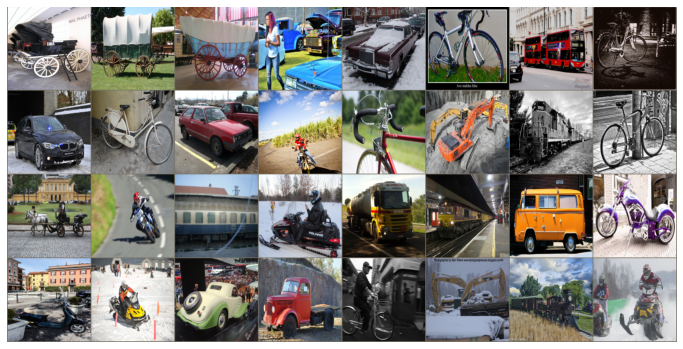

Prediction:
wagon wagon wagon car car bicycle bus bicycle car bicycle car motorbike bicycle excavator train bicycle wagon motorbike train snowmobile truck train bus motorbike scooter snowmobile car truck bicycle excavator train snowmobile


In [43]:
valid_loader = next(iter(loaders['valid']))
print('Target:')
plot_dataloader(valid_loader)

for prediction in runner.predict_loader(loader=loaders['valid']):
    print('Prediction:')
    logits = prediction['logits'].detach().cpu().numpy().argmax(axis=1)
    print(' '.join(f'{labels[logits[i]]}' for i in range(32)))
    break

Plots of model prediction accuracy and model loss on the test set during training are shown below.

In [39]:
def plot_metric(acc, loss):
    figure, ax = pylab.subplots(1, 2, figsize=(20, 5))
    sns.set_theme(style='whitegrid', palette='cool')
    
    ax[0] = sns.lineplot(data=acc, ax=ax[0])
    ax[0].set(xlabel='Epoch')
    ax[0].set(ylabel='Value')
    ax[0].set_title('Test Accuracy')
    
    ax[1] = sns.lineplot(data=loss, ax=ax[1])
    ax[1].set(xlabel='Epoch')
    ax[1].set(ylabel='Value')
    ax[1].set_title('Test Loss')
    
    pylab.show()

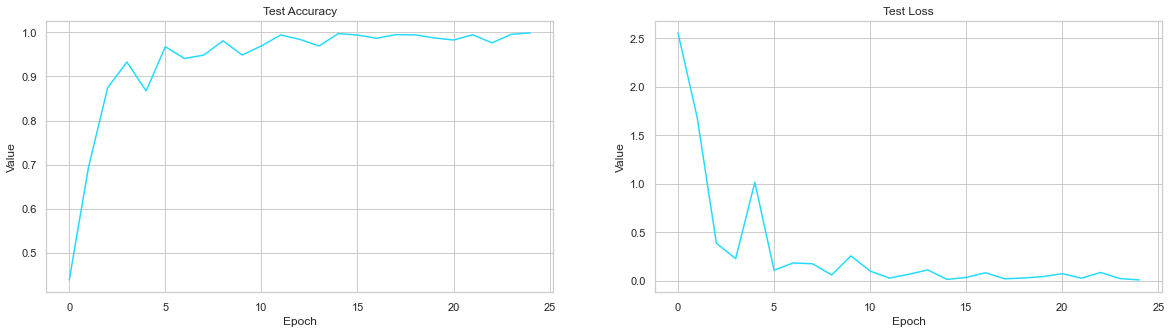

In [40]:
dataframe = ps.read_csv('./logs/csv_logger/valid.csv')
plot_metric(acc=dataframe['accuracy01'], loss=dataframe['loss'])